In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim

import optuna

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc,matthews_corrcoef, precision_recall_curve,roc_auc_score



データ読み取り

In [9]:
df=pd.read_csv('../../data/learning_data.csv',index_col=0)

X=df.drop(columns='dengue',axis=1).values
y=df['dengue'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1,random_state=42)

#torchテンソルに変換
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)


In [10]:
class DNN(nn.Module):
    def __init__(self, input_dim,hidden_units1,hidden_units2,hidden_units3,hidden_units4,dropout_rate):
        super(DNN, self).__init__()
        self.layer1 = nn.Linear(input_dim,hidden_units1)
        self.layer2 = nn.Linear(hidden_units1,hidden_units2)
        self.layer3 = nn.Linear(hidden_units2, hidden_units3)
        self.layer4 = nn.Linear(hidden_units3, hidden_units4)
        self.output_layer = nn.Linear(hidden_units4, 1)

        self.dropout = nn.Dropout(dropout_rate)

        self.bn1 = nn.BatchNorm1d(hidden_units1)
        self.bn2 = nn.BatchNorm1d(hidden_units2)
        self.bn3 = nn.BatchNorm1d(hidden_units3)
        self.bn4 = nn.BatchNorm1d(hidden_units4)

        
        
    def forward(self, x):
        x = torch.relu(self.bn1(self.layer1(x)))
        x = self.dropout(x)
        
        x = torch.relu(self.bn2(self.layer2(x)))
        x = self.dropout(x)

        x = torch.relu(self.bn3(self.layer3(x)))
        x = self.dropout(x)

        x = torch.relu(self.bn4(self.layer4(x)))
        x = self.dropout(x)

        x = torch.sigmoid(self.output_layer(x)) 
        return x
    

学習データセットの作成

In [11]:
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)

val_dataset = torch.utils.data.TensorDataset(X_val_tensor, y_val_tensor)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=32, shuffle=False)

Optunaの設定

In [ ]:
def objective(trial):
    hidden_units1 = trial.suggest_int("hidden_units1", 216, 512, step=2)
    hidden_units2 = trial.suggest_int("hidden_units2", 128, 216, step=2)
    hidden_units3 = trial.suggest_int("hidden_units3", 64, 128, step=2)
    hidden_units4 = trial.suggest_int("hidden_units4", 4, 64, step=2)
    dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5, step=0.05)
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
    weight_decay=trial.suggest_loguniform("weight_decay",1e-5,1)

    model = DNN(input_dim=X_train_tensor.shape[1], hidden_units1=hidden_units1,hidden_units2=hidden_units2,hidden_units3=hidden_units3,hidden_units4=hidden_units4, dropout_rate=dropout_rate).to(device)

    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,weight_decay=weight_decay)

    num_epochs = 100
    for epoch in range(num_epochs):
        model.train()
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch).squeeze()
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

    
    model.eval()
    val_true, val_pred, val_prob = [], [], []
    with torch.no_grad():
        for X_val, y_val in val_loader:
            X_val, y_val = X_val.to(device), y_val.to(device)
            val_outputs = model(X_val).squeeze()
            predictions = (val_outputs >= 0.5).float()
            val_true.extend(y_val.cpu().numpy())
            val_pred.extend(predictions.cpu().numpy())
            val_prob.extend(val_outputs.cpu().numpy())


    accuracy = accuracy_score(val_true, val_pred)
    precision = precision_score(val_true, val_pred)
    recall = recall_score(val_true, val_pred)
    f1 = f1_score(val_true, val_pred)
    mcc = matthews_corrcoef(val_true, val_pred)
    specificity = recall_score(val_true, val_pred, pos_label=0)

    # ログ
    print(f'Accuracy: {accuracy * 100:.2f}%')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print(f'Matthews Correlation Coefficient: {mcc:.4f}')
    print(f'Specificity: {specificity:.4f}')

    return precision


In [13]:
# 使用可能なGPUの数を取得
num_gpus = torch.cuda.device_count()

if num_gpus == 0:
    print("使用可能なGPUはありません。")
else:
    print(f"使用可能なGPUの数: {num_gpus}")
    for i in range(num_gpus):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
        print(f"  メモリ使用状況: {torch.cuda.memory_allocated(i) / 1024**2:.2f} MB / {torch.cuda.get_device_properties(i).total_memory / 1024**2:.2f} MB")
        print(f"  CUDA対応バージョン: {torch.cuda.get_device_properties(i).major}.{torch.cuda.get_device_properties(i).minor}")


使用可能なGPUの数: 2
GPU 0: NVIDIA GeForce GTX 1080 Ti
  メモリ使用状況: 8.65 MB / 11169.31 MB
  CUDA対応バージョン: 6.1
GPU 1: NVIDIA GeForce GTX 1080 Ti
  メモリ使用状況: 0.00 MB / 11172.19 MB
  CUDA対応バージョン: 6.1


最適化

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

study = optuna.create_study(direction="maximize")  
study.optimize(objective, n_trials=100)


print("Best Parameters: ", study.best_params)
print("Best Validation F1: ", study.best_value)


[I 2024-11-28 19:04:05,137] A new study created in memory with name: no-name-ecf6330c-45bb-43ba-bae8-28d28cc2e1fa
/tmp/ipykernel_181066/360301711.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
[I 2024-11-28 19:04:53,878] Trial 0 finished with value: 0.0 and parameters: {'hidden_units1': 440, 'hidden_units2': 134, 'hidden_units3': 110, 'hidden_units4': 50, 'dropout_rate': 0.35, 'learning_rate': 0.039218879581727054}. Best is tria

Accuracy: 64.10%
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
Matthews Correlation Coefficient: 0.0000
Specificity: 1.0000


[I 2024-11-28 19:05:44,283] Trial 1 finished with value: 0.5696594427244582 and parameters: {'hidden_units1': 376, 'hidden_units2': 192, 'hidden_units3': 106, 'hidden_units4': 40, 'dropout_rate': 0.30000000000000004, 'learning_rate': 0.028694027652947384}. Best is trial 1 with value: 0.5696594427244582.


Accuracy: 60.40%
Precision: 0.4670
Recall: 0.7302
F1 Score: 0.5697
Matthews Correlation Coefficient: 0.2547
Specificity: 0.5333


/tmp/ipykernel_181066/360301711.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
[I 2024-11-28 19:06:32,921] Trial 2 finished with value: 0.4351464435146444 and parameters: {'hidden_units1': 344, 'hidden_units2': 190, 'hidden_units3': 80, 'hidden_units4': 38, 'dropout_rate': 0.30000000000000004, 'learning_rate': 0.00035150533991268584}. Best is trial 1 with value: 0.5696594427244582.


Accuracy: 61.54%
Precision: 0.4602
Recall: 0.4127
F1 Score: 0.4351
Matthews Correlation Coefficient: 0.1454
Specificity: 0.7289


/tmp/ipykernel_181066/360301711.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
[I 2024-11-28 19:07:22,969] Trial 3 finished with value: 0.4765957446808511 and parameters: {'hidden_units1': 438, 'hidden_units2': 188, 'hidden_units3': 78, 'hidden_units4': 8, 'dropout_rate': 0.2, 'learning_rate': 0.010040441568639426}. Best is trial 1 with value: 0.5696594427244582.


Accuracy: 64.96%
Precision: 0.5138
Recall: 0.4444
F1 Score: 0.4766
Matthews Correlation Coefficient: 0.2166
Specificity: 0.7644


/tmp/ipykernel_181066/360301711.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
[I 2024-11-28 19:08:12,717] Trial 4 finished with value: 0.37073170731707317 and parameters: {'hidden_units1': 332, 'hidden_units2': 184, 'hidden_units3': 128, 'hidden_units4': 6, 'dropout_rate': 0.4, 'learning_rate': 0.0003905722406213182}. Best is trial 1 with value: 0.5696594427244582.


Accuracy: 63.25%
Precision: 0.4810
Recall: 0.3016
F1 Score: 0.3707
Matthews Correlation Coefficient: 0.1371
Specificity: 0.8178


/tmp/ipykernel_181066/360301711.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
[I 2024-11-28 19:09:01,386] Trial 5 finished with value: 0.37272727272727274 and parameters: {'hidden_units1': 462, 'hidden_units2': 206, 'hidden_units3': 68, 'hidden_units4': 32, 'dropout_rate': 0.4, 'learning_rate': 0.00011457797637875474}. Best is trial 1 with value: 0.5696594427244582.


Accuracy: 60.68%
Precision: 0.4362
Recall: 0.3254
F1 Score: 0.3727
Matthews Correlation Coefficient: 0.0973
Specificity: 0.7644


/tmp/ipykernel_181066/360301711.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
[I 2024-11-28 19:09:49,970] Trial 6 finished with value: 0.48854961832061067 and parameters: {'hidden_units1': 398, 'hidden_units2': 210, 'hidden_units3': 94, 'hidden_units4': 20, 'dropout_rate': 0.1, 'learning_rate': 0.02244550435208195}. Best is trial 1 with value: 0.5696594427244582.


Accuracy: 61.82%
Precision: 0.4706
Recall: 0.5079
F1 Score: 0.4885
Matthews Correlation Coefficient: 0.1851
Specificity: 0.6800


/tmp/ipykernel_181066/360301711.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
[I 2024-11-28 19:10:40,074] Trial 7 finished with value: 0.484375 and parameters: {'hidden_units1': 506, 'hidden_units2': 208, 'hidden_units3': 102, 'hidden_units4': 48, 'dropout_rate': 0.45000000000000007, 'learning_rate': 0.0002648870221120815}. Best is trial 1 with value: 0.5696594427244582.


Accuracy: 62.39%
Precision: 0.4769
Recall: 0.4921
F1 Score: 0.4844
Matthews Correlation Coefficient: 0.1886
Specificity: 0.6978


/tmp/ipykernel_181066/360301711.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
[I 2024-11-28 19:11:28,497] Trial 8 finished with value: 0.6120218579234973 and parameters: {'hidden_units1': 340, 'hidden_units2': 216, 'hidden_units3': 108, 'hidden_units4': 32, 'dropout_rate': 0.35, 'learning_rate': 1.0885153403779476e-05}. Best is trial 8 with value: 0.6120218579234973.


Accuracy: 59.54%
Precision: 0.4667
Recall: 0.8889
F1 Score: 0.6120
Matthews Correlation Coefficient: 0.3301
Specificity: 0.4311


/tmp/ipykernel_181066/360301711.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
[I 2024-11-28 19:12:17,113] Trial 9 finished with value: 0.49814126394052044 and parameters: {'hidden_units1': 460, 'hidden_units2': 180, 'hidden_units3': 122, 'hidden_units4': 50, 'dropout_rate': 0.4, 'learning_rate': 0.016855796887157295}. Best is trial 8 with value: 0.6120218579234973.


Accuracy: 61.54%
Precision: 0.4685
Recall: 0.5317
F1 Score: 0.4981
Matthews Correlation Coefficient: 0.1894
Specificity: 0.6622


/tmp/ipykernel_181066/360301711.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
[I 2024-11-28 19:13:04,157] Trial 10 finished with value: 0.5882352941176471 and parameters: {'hidden_units1': 232, 'hidden_units2': 158, 'hidden_units3': 92, 'hidden_units4': 24, 'dropout_rate': 0.5, 'learning_rate': 1.1130488251464775e-05}. Best is trial 8 with value: 0.6120218579234973.


Accuracy: 60.11%
Precision: 0.4673
Recall: 0.7937
F1 Score: 0.5882
Matthews Correlation Coefficient: 0.2822
Specificity: 0.4933


/tmp/ipykernel_181066/360301711.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
[I 2024-11-28 19:13:52,771] Trial 11 finished with value: 0.0 and parameters: {'hidden_units1': 234, 'hidden_units2': 154, 'hidden_units3': 90, 'hidden_units4': 22, 'dropout_rate': 0.5, 'learning_rate': 1.0095690900278788e-05}. Best is trial 8 with value: 0.6120218579234973.


Accuracy: 63.82%
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
Matthews Correlation Coefficient: -0.0400
Specificity: 0.9956


/tmp/ipykernel_181066/360301711.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
[I 2024-11-28 19:14:41,597] Trial 12 finished with value: 0.5369127516778524 and parameters: {'hidden_units1': 226, 'hidden_units2': 162, 'hidden_units3': 116, 'hidden_units4': 26, 'dropout_rate': 0.5, 'learning_rate': 1.0310094047574425e-05}. Best is trial 8 with value: 0.6120218579234973.


Accuracy: 60.68%
Precision: 0.4651
Recall: 0.6349
F1 Score: 0.5369
Matthews Correlation Coefficient: 0.2169
Specificity: 0.5911


/tmp/ipykernel_181066/360301711.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
[I 2024-11-28 19:15:29,984] Trial 13 finished with value: 0.5 and parameters: {'hidden_units1': 288, 'hidden_units2': 144, 'hidden_units3': 84, 'hidden_units4': 60, 'dropout_rate': 0.2, 'learning_rate': 3.7997705347343164e-05}. Best is trial 8 with value: 0.6120218579234973.


Accuracy: 60.68%
Precision: 0.4600
Recall: 0.5476
F1 Score: 0.5000
Matthews Correlation Coefficient: 0.1819
Specificity: 0.6400


/tmp/ipykernel_181066/360301711.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
[I 2024-11-28 19:16:20,225] Trial 14 finished with value: 0.46875 and parameters: {'hidden_units1': 278, 'hidden_units2': 168, 'hidden_units3': 100, 'hidden_units4': 14, 'dropout_rate': 0.2, 'learning_rate': 0.0040091100621782085}. Best is trial 8 with value: 0.6120218579234973.


Accuracy: 61.25%
Precision: 0.4615
Recall: 0.4762
F1 Score: 0.4688
Matthews Correlation Coefficient: 0.1640
Specificity: 0.6889


/tmp/ipykernel_181066/360301711.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
[I 2024-11-28 19:17:10,813] Trial 15 finished with value: 0.415929203539823 and parameters: {'hidden_units1': 294, 'hidden_units2': 152, 'hidden_units3': 112, 'hidden_units4': 30, 'dropout_rate': 0.45000000000000007, 'learning_rate': 3.551834679186566e-05}. Best is trial 8 with value: 0.6120218579234973.


Accuracy: 62.39%
Precision: 0.4700
Recall: 0.3730
F1 Score: 0.4159
Matthews Correlation Coefficient: 0.1461
Specificity: 0.7644


/tmp/ipykernel_181066/360301711.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
[I 2024-11-28 19:17:59,542] Trial 16 finished with value: 0.4388185654008439 and parameters: {'hidden_units1': 248, 'hidden_units2': 128, 'hidden_units3': 90, 'hidden_units4': 18, 'dropout_rate': 0.25, 'learning_rate': 0.001821624147939065}. Best is trial 8 with value: 0.6120218579234973.


Accuracy: 62.11%
Precision: 0.4685
Recall: 0.4127
F1 Score: 0.4388
Matthews Correlation Coefficient: 0.1552
Specificity: 0.7378


/tmp/ipykernel_181066/360301711.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
[I 2024-11-28 19:18:48,603] Trial 17 finished with value: 0.39826839826839827 and parameters: {'hidden_units1': 314, 'hidden_units2': 216, 'hidden_units3': 64, 'hidden_units4': 40, 'dropout_rate': 0.35, 'learning_rate': 4.351066185573741e-05}. Best is trial 8 with value: 0.6120218579234973.


Accuracy: 60.40%
Precision: 0.4381
Recall: 0.3651
F1 Score: 0.3983
Matthews Correlation Coefficient: 0.1078
Specificity: 0.7378


/tmp/ipykernel_181066/360301711.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
[I 2024-11-28 19:19:37,765] Trial 18 finished with value: 0.5054151624548736 and parameters: {'hidden_units1': 260, 'hidden_units2': 174, 'hidden_units3': 98, 'hidden_units4': 14, 'dropout_rate': 0.1, 'learning_rate': 7.422455270805352e-05}. Best is trial 8 with value: 0.6120218579234973.


Accuracy: 60.97%
Precision: 0.4636
Recall: 0.5556
F1 Score: 0.5054
Matthews Correlation Coefficient: 0.1895
Specificity: 0.6400


/tmp/ipykernel_181066/360301711.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
[I 2024-11-28 19:20:26,544] Trial 19 finished with value: 0.5850746268656717 and parameters: {'hidden_units1': 392, 'hidden_units2': 196, 'hidden_units3': 120, 'hidden_units4': 26, 'dropout_rate': 0.45000000000000007, 'learning_rate': 1.8648930728942516e-05}. Best is trial 8 with value: 0.6120218579234973.


Accuracy: 60.40%
Precision: 0.4689
Recall: 0.7778
F1 Score: 0.5851
Matthews Correlation Coefficient: 0.2780
Specificity: 0.5067


/tmp/ipykernel_181066/360301711.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
[I 2024-11-28 19:21:15,026] Trial 20 finished with value: 0.4691358024691358 and parameters: {'hidden_units1': 340, 'hidden_units2': 160, 'hidden_units3': 74, 'hidden_units4': 64, 'dropout_rate': 0.35, 'learning_rate': 0.00016025342600970078}. Best is trial 8 with value: 0.6120218579234973.


Accuracy: 63.25%
Precision: 0.4872
Recall: 0.4524
F1 Score: 0.4691
Matthews Correlation Coefficient: 0.1890
Specificity: 0.7333


/tmp/ipykernel_181066/360301711.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
[I 2024-11-28 19:22:04,061] Trial 21 finished with value: 0.5988023952095808 and parameters: {'hidden_units1': 392, 'hidden_units2': 202, 'hidden_units3': 118, 'hidden_units4': 26, 'dropout_rate': 0.45000000000000007, 'learning_rate': 1.7647836989834258e-05}. Best is trial 8 with value: 0.6120218579234973.


Accuracy: 61.82%
Precision: 0.4808
Recall: 0.7937
F1 Score: 0.5988
Matthews Correlation Coefficient: 0.3062
Specificity: 0.5200


/tmp/ipykernel_181066/360301711.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
[I 2024-11-28 19:22:51,907] Trial 22 finished with value: 0.6133333333333333 and parameters: {'hidden_units1': 414, 'hidden_units2': 200, 'hidden_units3': 108, 'hidden_units4': 34, 'dropout_rate': 0.5, 'learning_rate': 2.1442977375325725e-05}. Best is trial 22 with value: 0.6133333333333333.


Accuracy: 58.69%
Precision: 0.4618
Recall: 0.9127
F1 Score: 0.6133
Matthews Correlation Coefficient: 0.3351
Specificity: 0.4044


/tmp/ipykernel_181066/360301711.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
[I 2024-11-28 19:23:40,380] Trial 23 finished with value: 0.6136986301369863 and parameters: {'hidden_units1': 408, 'hidden_units2': 198, 'hidden_units3': 106, 'hidden_units4': 36, 'dropout_rate': 0.45000000000000007, 'learning_rate': 2.4962533274852878e-05}. Best is trial 23 with value: 0.6136986301369863.


Accuracy: 59.83%
Precision: 0.4686
Recall: 0.8889
F1 Score: 0.6137
Matthews Correlation Coefficient: 0.3339
Specificity: 0.4356


/tmp/ipykernel_181066/360301711.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
[I 2024-11-28 19:24:28,967] Trial 24 finished with value: 0.0 and parameters: {'hidden_units1': 418, 'hidden_units2': 216, 'hidden_units3': 106, 'hidden_units4': 36, 'dropout_rate': 0.5, 'learning_rate': 0.09103040300255533}. Best is trial 23 with value: 0.6136986301369863.
/tmp/ipykernel_181066/360301711.py:7: FutureWarning: suggest_loguniform has be

Accuracy: 64.10%
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
Matthews Correlation Coefficient: 0.0000
Specificity: 1.0000


[I 2024-11-28 19:25:17,749] Trial 25 finished with value: 0.41284403669724773 and parameters: {'hidden_units1': 362, 'hidden_units2': 200, 'hidden_units3': 110, 'hidden_units4': 44, 'dropout_rate': 0.4, 'learning_rate': 6.97018391068961e-05}. Best is trial 23 with value: 0.6136986301369863.


Accuracy: 63.53%
Precision: 0.4891
Recall: 0.3571
F1 Score: 0.4128
Matthews Correlation Coefficient: 0.1617
Specificity: 0.7911


/tmp/ipykernel_181066/360301711.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
[I 2024-11-28 19:26:06,966] Trial 26 finished with value: 0.4262295081967213 and parameters: {'hidden_units1': 488, 'hidden_units2': 196, 'hidden_units3': 104, 'hidden_units4': 30, 'dropout_rate': 0.45000000000000007, 'learning_rate': 0.0010802813732470437}. Best is trial 23 with value: 0.6136986301369863.


Accuracy: 60.11%
Precision: 0.4407
Recall: 0.4127
F1 Score: 0.4262
Matthews Correlation Coefficient: 0.1212
Specificity: 0.7067


/tmp/ipykernel_181066/360301711.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
[I 2024-11-28 19:26:55,979] Trial 27 finished with value: 0.43902439024390244 and parameters: {'hidden_units1': 420, 'hidden_units2': 212, 'hidden_units3': 126, 'hidden_units4': 44, 'dropout_rate': 0.35, 'learning_rate': 2.0327435403518873e-05}. Best is trial 23 with value: 0.6136986301369863.


Accuracy: 60.68%
Precision: 0.4500
Recall: 0.4286
F1 Score: 0.4390
Matthews Correlation Coefficient: 0.1368
Specificity: 0.7067


/tmp/ipykernel_181066/360301711.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
[I 2024-11-28 19:27:44,521] Trial 28 finished with value: 0.5754385964912281 and parameters: {'hidden_units1': 366, 'hidden_units2': 204, 'hidden_units3': 114, 'hidden_units4': 56, 'dropout_rate': 0.25, 'learning_rate': 3.063880846258753e-05}. Best is trial 23 with value: 0.6136986301369863.


Accuracy: 65.53%
Precision: 0.5157
Recall: 0.6508
F1 Score: 0.5754
Matthews Correlation Coefficient: 0.2974
Specificity: 0.6578


/tmp/ipykernel_181066/360301711.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
[I 2024-11-28 19:28:33,593] Trial 29 finished with value: 0.509090909090909 and parameters: {'hidden_units1': 416, 'hidden_units2': 174, 'hidden_units3': 110, 'hidden_units4': 32, 'dropout_rate': 0.4, 'learning_rate': 8.265834086549987e-05}. Best is trial 23 with value: 0.6136986301369863.


Accuracy: 61.54%
Precision: 0.4698
Recall: 0.5556
F1 Score: 0.5091
Matthews Correlation Coefficient: 0.1984
Specificity: 0.6489


/tmp/ipykernel_181066/360301711.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
[I 2024-11-28 19:29:21,752] Trial 30 finished with value: 0.488 and parameters: {'hidden_units1': 442, 'hidden_units2': 196, 'hidden_units3': 98, 'hidden_units4': 46, 'dropout_rate': 0.5, 'learning_rate': 0.0001924684154370105}. Best is trial 23 with value: 0.6136986301369863.


Accuracy: 63.53%
Precision: 0.4919
Recall: 0.4841
F1 Score: 0.4880
Matthews Correlation Coefficient: 0.2049
Specificity: 0.7200


/tmp/ipykernel_181066/360301711.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
[I 2024-11-28 19:30:10,523] Trial 31 finished with value: 0.5441176470588235 and parameters: {'hidden_units1': 390, 'hidden_units2': 202, 'hidden_units3': 118, 'hidden_units4': 36, 'dropout_rate': 0.45000000000000007, 'learning_rate': 1.9288284370818813e-05}. Best is trial 23 with value: 0.6136986301369863.


Accuracy: 64.67%
Precision: 0.5068
Recall: 0.5873
F1 Score: 0.5441
Matthews Correlation Coefficient: 0.2602
Specificity: 0.6800


/tmp/ipykernel_181066/360301711.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
[I 2024-11-28 19:30:58,965] Trial 32 finished with value: 0.5988700564971752 and parameters: {'hidden_units1': 376, 'hidden_units2': 182, 'hidden_units3': 110, 'hidden_units4': 28, 'dropout_rate': 0.45000000000000007, 'learning_rate': 1.9882020489313842e-05}. Best is trial 23 with value: 0.6136986301369863.


Accuracy: 59.54%
Precision: 0.4649
Recall: 0.8413
F1 Score: 0.5989
Matthews Correlation Coefficient: 0.3007
Specificity: 0.4578


/tmp/ipykernel_181066/360301711.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
[I 2024-11-28 19:31:47,583] Trial 33 finished with value: 0.5460992907801419 and parameters: {'hidden_units1': 354, 'hidden_units2': 184, 'hidden_units3': 108, 'hidden_units4': 40, 'dropout_rate': 0.30000000000000004, 'learning_rate': 5.526493821480091e-05}. Best is trial 23 with value: 0.6136986301369863.


Accuracy: 63.53%
Precision: 0.4936
Recall: 0.6111
F1 Score: 0.5461
Matthews Correlation Coefficient: 0.2510
Specificity: 0.6489


/tmp/ipykernel_181066/360301711.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
[I 2024-11-28 19:32:36,940] Trial 34 finished with value: 0.6129032258064516 and parameters: {'hidden_units1': 376, 'hidden_units2': 190, 'hidden_units3': 106, 'hidden_units4': 36, 'dropout_rate': 0.5, 'learning_rate': 2.7103665053167682e-05}. Best is trial 23 with value: 0.6136986301369863.


Accuracy: 58.97%
Precision: 0.4634
Recall: 0.9048
F1 Score: 0.6129
Matthews Correlation Coefficient: 0.3333
Specificity: 0.4133


/tmp/ipykernel_181066/360301711.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
[I 2024-11-28 19:33:27,362] Trial 35 finished with value: 0.43478260869565216 and parameters: {'hidden_units1': 318, 'hidden_units2': 190, 'hidden_units3': 106, 'hidden_units4': 34, 'dropout_rate': 0.5, 'learning_rate': 0.0004283194654026467}. Best is trial 23 with value: 0.6136986301369863.


Accuracy: 62.96%
Precision: 0.4808
Recall: 0.3968
F1 Score: 0.4348
Matthews Correlation Coefficient: 0.1648
Specificity: 0.7600


/tmp/ipykernel_181066/360301711.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
[I 2024-11-28 19:34:15,522] Trial 36 finished with value: 0.5945945945945946 and parameters: {'hidden_units1': 438, 'hidden_units2': 192, 'hidden_units3': 102, 'hidden_units4': 42, 'dropout_rate': 0.35, 'learning_rate': 2.9554146989004805e-05}. Best is trial 23 with value: 0.6136986301369863.


Accuracy: 61.54%
Precision: 0.4783
Recall: 0.7857
F1 Score: 0.5946
Matthews Correlation Coefficient: 0.2981
Specificity: 0.5200


/tmp/ipykernel_181066/360301711.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
[I 2024-11-28 19:35:04,676] Trial 37 finished with value: 0.49242424242424243 and parameters: {'hidden_units1': 318, 'hidden_units2': 212, 'hidden_units3': 96, 'hidden_units4': 54, 'dropout_rate': 0.5, 'learning_rate': 0.00011441477397586893}. Best is trial 23 with value: 0.6136986301369863.


Accuracy: 61.82%
Precision: 0.4710
Recall: 0.5159
F1 Score: 0.4924
Matthews Correlation Coefficient: 0.1880
Specificity: 0.6756


/tmp/ipykernel_181066/360301711.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
[I 2024-11-28 19:35:53,717] Trial 38 finished with value: 0.48031496062992124 and parameters: {'hidden_units1': 378, 'hidden_units2': 198, 'hidden_units3': 114, 'hidden_units4': 38, 'dropout_rate': 0.4, 'learning_rate': 0.000518220830284348}. Best is trial 23 with value: 0.6136986301369863.


Accuracy: 62.39%
Precision: 0.4766
Recall: 0.4841
F1 Score: 0.4803
Matthews Correlation Coefficient: 0.1857
Specificity: 0.7022


/tmp/ipykernel_181066/360301711.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
[I 2024-11-28 19:36:42,671] Trial 39 finished with value: 0.5156794425087108 and parameters: {'hidden_units1': 410, 'hidden_units2': 186, 'hidden_units3': 86, 'hidden_units4': 34, 'dropout_rate': 0.25, 'learning_rate': 0.00011820631447473334}. Best is trial 23 with value: 0.6136986301369863.


Accuracy: 60.40%
Precision: 0.4596
Recall: 0.5873
F1 Score: 0.5157
Matthews Correlation Coefficient: 0.1931
Specificity: 0.6133


/tmp/ipykernel_181066/360301711.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
[I 2024-11-28 19:37:32,794] Trial 40 finished with value: 0.5196850393700787 and parameters: {'hidden_units1': 458, 'hidden_units2': 206, 'hidden_units3': 124, 'hidden_units4': 38, 'dropout_rate': 0.30000000000000004, 'learning_rate': 0.004589244508420564}. Best is trial 23 with value: 0.6136986301369863.


Accuracy: 65.24%
Precision: 0.5156
Recall: 0.5238
F1 Score: 0.5197
Matthews Correlation Coefficient: 0.2474
Specificity: 0.7244


/tmp/ipykernel_181066/360301711.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
[I 2024-11-28 19:38:21,505] Trial 41 finished with value: 0.6128133704735376 and parameters: {'hidden_units1': 374, 'hidden_units2': 178, 'hidden_units3': 108, 'hidden_units4': 30, 'dropout_rate': 0.45000000000000007, 'learning_rate': 1.6187586515033107e-05}. Best is trial 23 with value: 0.6136986301369863.


Accuracy: 60.40%
Precision: 0.4721
Recall: 0.8730
F1 Score: 0.6128
Matthews Correlation Coefficient: 0.3314
Specificity: 0.4533


/tmp/ipykernel_181066/360301711.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
[I 2024-11-28 19:39:10,700] Trial 42 finished with value: 0.6 and parameters: {'hidden_units1': 350, 'hidden_units2': 178, 'hidden_units3': 102, 'hidden_units4': 30, 'dropout_rate': 0.45000000000000007, 'learning_rate': 1.5125330126626373e-05}. Best is trial 23 with value: 0.6136986301369863.


Accuracy: 61.25%
Precision: 0.4766
Recall: 0.8095
F1 Score: 0.6000
Matthews Correlation Coefficient: 0.3066
Specificity: 0.5022


/tmp/ipykernel_181066/360301711.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
[I 2024-11-28 19:39:59,690] Trial 43 finished with value: 0.44609665427509293 and parameters: {'hidden_units1': 404, 'hidden_units2': 192, 'hidden_units3': 106, 'hidden_units4': 32, 'dropout_rate': 0.5, 'learning_rate': 2.9312030022576117e-05}. Best is trial 23 with value: 0.6136986301369863.


Accuracy: 57.55%
Precision: 0.4196
Recall: 0.4762
F1 Score: 0.4461
Matthews Correlation Coefficient: 0.1048
Specificity: 0.6311


/tmp/ipykernel_181066/360301711.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
[I 2024-11-28 19:40:48,335] Trial 44 finished with value: 0.5379310344827586 and parameters: {'hidden_units1': 330, 'hidden_units2': 168, 'hidden_units3': 114, 'hidden_units4': 20, 'dropout_rate': 0.4, 'learning_rate': 4.6342035919407684e-05}. Best is trial 23 with value: 0.6136986301369863.


Accuracy: 61.82%
Precision: 0.4756
Recall: 0.6190
F1 Score: 0.5379
Matthews Correlation Coefficient: 0.2277
Specificity: 0.6178


/tmp/ipykernel_181066/360301711.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
[I 2024-11-28 19:41:37,027] Trial 45 finished with value: 0.5819397993311036 and parameters: {'hidden_units1': 432, 'hidden_units2': 188, 'hidden_units3': 104, 'hidden_units4': 36, 'dropout_rate': 0.45000000000000007, 'learning_rate': 1.1822808763573946e-05}. Best is trial 23 with value: 0.6136986301369863.


Accuracy: 64.39%
Precision: 0.5029
Recall: 0.6905
F1 Score: 0.5819
Matthews Correlation Coefficient: 0.2958
Specificity: 0.6178


/tmp/ipykernel_181066/360301711.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
[I 2024-11-28 19:42:26,442] Trial 46 finished with value: 0.6157894736842106 and parameters: {'hidden_units1': 380, 'hidden_units2': 178, 'hidden_units3': 108, 'hidden_units4': 48, 'dropout_rate': 0.5, 'learning_rate': 2.50776950804859e-05}. Best is trial 46 with value: 0.6157894736842106.


Accuracy: 58.40%
Precision: 0.4606
Recall: 0.9286
F1 Score: 0.6158
Matthews Correlation Coefficient: 0.3429
Specificity: 0.3911


/tmp/ipykernel_181066/360301711.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
[I 2024-11-28 19:43:16,770] Trial 47 finished with value: 0.5977653631284916 and parameters: {'hidden_units1': 372, 'hidden_units2': 178, 'hidden_units3': 94, 'hidden_units4': 48, 'dropout_rate': 0.5, 'learning_rate': 2.3906982507870842e-05}. Best is trial 46 with value: 0.6157894736842106.


Accuracy: 58.97%
Precision: 0.4612
Recall: 0.8492
F1 Score: 0.5978
Matthews Correlation Coefficient: 0.2976
Specificity: 0.4444


/tmp/ipykernel_181066/360301711.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
[I 2024-11-28 19:44:05,955] Trial 48 finished with value: 0.6153846153846154 and parameters: {'hidden_units1': 384, 'hidden_units2': 170, 'hidden_units3': 112, 'hidden_units4': 52, 'dropout_rate': 0.5, 'learning_rate': 5.68045025979691e-05}. Best is trial 46 with value: 0.6157894736842106.


Accuracy: 60.11%
Precision: 0.4706
Recall: 0.8889
F1 Score: 0.6154
Matthews Correlation Coefficient: 0.3377
Specificity: 0.4400


/tmp/ipykernel_181066/360301711.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
[I 2024-11-28 19:44:55,423] Trial 49 finished with value: 0.48120300751879697 and parameters: {'hidden_units1': 386, 'hidden_units2': 166, 'hidden_units3': 112, 'hidden_units4': 56, 'dropout_rate': 0.5, 'learning_rate': 0.00024369204922680888}. Best is trial 46 with value: 0.6157894736842106.


Accuracy: 60.68%
Precision: 0.4571
Recall: 0.5079
F1 Score: 0.4812
Matthews Correlation Coefficient: 0.1667
Specificity: 0.6622


/tmp/ipykernel_181066/360301711.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
[I 2024-11-28 19:45:44,639] Trial 50 finished with value: 0.6038781163434903 and parameters: {'hidden_units1': 426, 'hidden_units2': 172, 'hidden_units3': 100, 'hidden_units4': 46, 'dropout_rate': 0.5, 'learning_rate': 5.531902143867887e-05}. Best is trial 46 with value: 0.6157894736842106.


Accuracy: 59.26%
Precision: 0.4638
Recall: 0.8651
F1 Score: 0.6039
Matthews Correlation Coefficient: 0.3111
Specificity: 0.4400


/tmp/ipykernel_181066/360301711.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
[I 2024-11-28 19:46:33,687] Trial 51 finished with value: 0.6070460704607046 and parameters: {'hidden_units1': 404, 'hidden_units2': 178, 'hidden_units3': 116, 'hidden_units4': 50, 'dropout_rate': 0.45000000000000007, 'learning_rate': 1.4237121433352127e-05}. Best is trial 46 with value: 0.6157894736842106.


Accuracy: 58.69%
Precision: 0.4609
Recall: 0.8889
F1 Score: 0.6070
Matthews Correlation Coefficient: 0.3187
Specificity: 0.4178


/tmp/ipykernel_181066/360301711.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
[I 2024-11-28 19:47:22,961] Trial 52 finished with value: 0.6081871345029239 and parameters: {'hidden_units1': 362, 'hidden_units2': 172, 'hidden_units3': 108, 'hidden_units4': 52, 'dropout_rate': 0.5, 'learning_rate': 2.7703677054902837e-05}. Best is trial 46 with value: 0.6157894736842106.


Accuracy: 61.82%
Precision: 0.4815
Recall: 0.8254
F1 Score: 0.6082
Matthews Correlation Coefficient: 0.3230
Specificity: 0.5022


/tmp/ipykernel_181066/360301711.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
[I 2024-11-28 19:48:11,513] Trial 53 finished with value: 0.6256410256410256 and parameters: {'hidden_units1': 452, 'hidden_units2': 164, 'hidden_units3': 112, 'hidden_units4': 58, 'dropout_rate': 0.5, 'learning_rate': 4.2763059550763196e-05}. Best is trial 53 with value: 0.6256410256410256.


Accuracy: 58.40%
Precision: 0.4621
Recall: 0.9683
F1 Score: 0.6256
Matthews Correlation Coefficient: 0.3746
Specificity: 0.3689


/tmp/ipykernel_181066/360301711.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
[I 2024-11-28 19:48:59,129] Trial 54 finished with value: 0.6266318537859008 and parameters: {'hidden_units1': 448, 'hidden_units2': 148, 'hidden_units3': 112, 'hidden_units4': 64, 'dropout_rate': 0.5, 'learning_rate': 9.347756116243938e-05}. Best is trial 54 with value: 0.6266318537859008.


Accuracy: 59.26%
Precision: 0.4669
Recall: 0.9524
F1 Score: 0.6266
Matthews Correlation Coefficient: 0.3721
Specificity: 0.3911


/tmp/ipykernel_181066/360301711.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
[I 2024-11-28 19:49:48,406] Trial 55 finished with value: 0.5309090909090909 and parameters: {'hidden_units1': 476, 'hidden_units2': 144, 'hidden_units3': 122, 'hidden_units4': 64, 'dropout_rate': 0.15000000000000002, 'learning_rate': 0.0001131538563009756}. Best is trial 54 with value: 0.6266318537859008.


Accuracy: 63.25%
Precision: 0.4899
Recall: 0.5794
F1 Score: 0.5309
Matthews Correlation Coefficient: 0.2345
Specificity: 0.6622


/tmp/ipykernel_181066/360301711.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
[I 2024-11-28 19:50:36,544] Trial 56 finished with value: 0.3813953488372093 and parameters: {'hidden_units1': 458, 'hidden_units2': 148, 'hidden_units3': 118, 'hidden_units4': 60, 'dropout_rate': 0.5, 'learning_rate': 8.092190565374643e-05}. Best is trial 54 with value: 0.6266318537859008.


Accuracy: 62.11%
Precision: 0.4607
Recall: 0.3254
F1 Score: 0.3814
Matthews Correlation Coefficient: 0.1236
Specificity: 0.7867


/tmp/ipykernel_181066/360301711.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
[I 2024-11-28 19:51:25,850] Trial 57 finished with value: 0.4017857142857143 and parameters: {'hidden_units1': 446, 'hidden_units2': 156, 'hidden_units3': 112, 'hidden_units4': 60, 'dropout_rate': 0.5, 'learning_rate': 4.2494637665804034e-05}. Best is trial 54 with value: 0.6266318537859008.


Accuracy: 61.82%
Precision: 0.4592
Recall: 0.3571
F1 Score: 0.4018
Matthews Correlation Coefficient: 0.1300
Specificity: 0.7644


/tmp/ipykernel_181066/360301711.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
[I 2024-11-28 19:52:14,662] Trial 58 finished with value: 0.5756676557863502 and parameters: {'hidden_units1': 480, 'hidden_units2': 134, 'hidden_units3': 116, 'hidden_units4': 58, 'dropout_rate': 0.45000000000000007, 'learning_rate': 5.8913252462588836e-05}. Best is trial 54 with value: 0.6266318537859008.


Accuracy: 59.26%
Precision: 0.4597
Recall: 0.7698
F1 Score: 0.5757
Matthews Correlation Coefficient: 0.2578
Specificity: 0.4933


/tmp/ipykernel_181066/360301711.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
[I 2024-11-28 19:53:04,406] Trial 59 finished with value: 0.4444444444444444 and parameters: {'hidden_units1': 450, 'hidden_units2': 164, 'hidden_units3': 122, 'hidden_units4': 62, 'dropout_rate': 0.5, 'learning_rate': 0.0006643067368592084}. Best is trial 54 with value: 0.6266318537859008.


Accuracy: 61.54%
Precision: 0.4615
Recall: 0.4286
F1 Score: 0.4444
Matthews Correlation Coefficient: 0.1512
Specificity: 0.7200


/tmp/ipykernel_181066/360301711.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
[I 2024-11-28 19:53:54,159] Trial 60 finished with value: 0.3755868544600939 and parameters: {'hidden_units1': 472, 'hidden_units2': 138, 'hidden_units3': 128, 'hidden_units4': 52, 'dropout_rate': 0.45000000000000007, 'learning_rate': 4.034542578241125e-05}. Best is trial 54 with value: 0.6266318537859008.


Accuracy: 62.11%
Precision: 0.4598
Recall: 0.3175
F1 Score: 0.3756
Matthews Correlation Coefficient: 0.1206
Specificity: 0.7911


/tmp/ipykernel_181066/360301711.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
[I 2024-11-28 19:54:42,245] Trial 61 finished with value: 0.6153846153846154 and parameters: {'hidden_units1': 400, 'hidden_units2': 160, 'hidden_units3': 104, 'hidden_units4': 56, 'dropout_rate': 0.5, 'learning_rate': 2.4910523165014477e-05}. Best is trial 54 with value: 0.6266318537859008.


Accuracy: 58.69%
Precision: 0.4622
Recall: 0.9206
F1 Score: 0.6154
Matthews Correlation Coefficient: 0.3408
Specificity: 0.4000


/tmp/ipykernel_181066/360301711.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
[I 2024-11-28 19:55:28,800] Trial 62 finished with value: 0.39090909090909093 and parameters: {'hidden_units1': 430, 'hidden_units2': 152, 'hidden_units3': 104, 'hidden_units4': 56, 'dropout_rate': 0.5, 'learning_rate': 0.0001647595756108738}. Best is trial 54 with value: 0.6266318537859008.


Accuracy: 61.82%
Precision: 0.4574
Recall: 0.3413
F1 Score: 0.3909
Matthews Correlation Coefficient: 0.1241
Specificity: 0.7733


/tmp/ipykernel_181066/360301711.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
[I 2024-11-28 19:56:16,797] Trial 63 finished with value: 0.6197916666666666 and parameters: {'hidden_units1': 410, 'hidden_units2': 160, 'hidden_units3': 112, 'hidden_units4': 62, 'dropout_rate': 0.5, 'learning_rate': 8.28657610773303e-05}. Best is trial 54 with value: 0.6266318537859008.


Accuracy: 58.40%
Precision: 0.4612
Recall: 0.9444
F1 Score: 0.6198
Matthews Correlation Coefficient: 0.3551
Specificity: 0.3822


/tmp/ipykernel_181066/360301711.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
[I 2024-11-28 19:57:03,638] Trial 64 finished with value: 0.5786163522012578 and parameters: {'hidden_units1': 508, 'hidden_units2': 160, 'hidden_units3': 112, 'hidden_units4': 62, 'dropout_rate': 0.5, 'learning_rate': 0.00010434164308116615}. Best is trial 54 with value: 0.6266318537859008.


Accuracy: 61.82%
Precision: 0.4792
Recall: 0.7302
F1 Score: 0.5786
Matthews Correlation Coefficient: 0.2753
Specificity: 0.5556


/tmp/ipykernel_181066/360301711.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
[I 2024-11-28 19:57:53,104] Trial 65 finished with value: 0.5134099616858238 and parameters: {'hidden_units1': 398, 'hidden_units2': 168, 'hidden_units3': 114, 'hidden_units4': 58, 'dropout_rate': 0.45000000000000007, 'learning_rate': 0.00023432165906237367}. Best is trial 54 with value: 0.6266318537859008.


Accuracy: 63.82%
Precision: 0.4963
Recall: 0.5317
F1 Score: 0.5134
Matthews Correlation Coefficient: 0.2263
Specificity: 0.6978


/tmp/ipykernel_181066/360301711.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
[I 2024-11-28 19:58:43,414] Trial 66 finished with value: 0.3027027027027027 and parameters: {'hidden_units1': 494, 'hidden_units2': 150, 'hidden_units3': 110, 'hidden_units4': 54, 'dropout_rate': 0.5, 'learning_rate': 7.468860634945811e-05}. Best is trial 54 with value: 0.6266318537859008.


Accuracy: 63.25%
Precision: 0.4746
Recall: 0.2222
F1 Score: 0.3027
Matthews Correlation Coefficient: 0.1083
Specificity: 0.8622


/tmp/ipykernel_181066/360301711.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
[I 2024-11-28 19:59:32,861] Trial 67 finished with value: 0.6183844011142061 and parameters: {'hidden_units1': 404, 'hidden_units2': 156, 'hidden_units3': 100, 'hidden_units4': 64, 'dropout_rate': 0.45000000000000007, 'learning_rate': 4.007980424458777e-05}. Best is trial 54 with value: 0.6266318537859008.


Accuracy: 60.97%
Precision: 0.4764
Recall: 0.8810
F1 Score: 0.6184
Matthews Correlation Coefficient: 0.3440
Specificity: 0.4578


/tmp/ipykernel_181066/360301711.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
[I 2024-11-28 20:00:22,257] Trial 68 finished with value: 0.5374149659863946 and parameters: {'hidden_units1': 396, 'hidden_units2': 156, 'hidden_units3': 100, 'hidden_units4': 62, 'dropout_rate': 0.5, 'learning_rate': 0.0003261803453249483}. Best is trial 54 with value: 0.6266318537859008.


Accuracy: 61.25%
Precision: 0.4702
Recall: 0.6270
F1 Score: 0.5374
Matthews Correlation Coefficient: 0.2222
Specificity: 0.6044


/tmp/ipykernel_181066/360301711.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
[I 2024-11-28 20:01:09,380] Trial 69 finished with value: 0.35467980295566504 and parameters: {'hidden_units1': 426, 'hidden_units2': 162, 'hidden_units3': 120, 'hidden_units4': 64, 'dropout_rate': 0.4, 'learning_rate': 4.854211887029666e-05}. Best is trial 54 with value: 0.6266318537859008.


Accuracy: 62.68%
Precision: 0.4675
Recall: 0.2857
F1 Score: 0.3547
Matthews Correlation Coefficient: 0.1200
Specificity: 0.8178


/tmp/ipykernel_181066/360301711.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
[I 2024-11-28 20:01:59,122] Trial 70 finished with value: 0.6206896551724138 and parameters: {'hidden_units1': 384, 'hidden_units2': 146, 'hidden_units3': 98, 'hidden_units4': 58, 'dropout_rate': 0.45000000000000007, 'learning_rate': 3.302469343964605e-05}. Best is trial 54 with value: 0.6266318537859008.


Accuracy: 59.26%
Precision: 0.4661
Recall: 0.9286
F1 Score: 0.6207
Matthews Correlation Coefficient: 0.3539
Specificity: 0.4044


/tmp/ipykernel_181066/360301711.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
[I 2024-11-28 20:02:47,780] Trial 71 finished with value: 0.6035502958579881 and parameters: {'hidden_units1': 386, 'hidden_units2': 144, 'hidden_units3': 98, 'hidden_units4': 58, 'dropout_rate': 0.45000000000000007, 'learning_rate': 6.723089087362898e-05}. Best is trial 54 with value: 0.6266318537859008.


Accuracy: 61.82%
Precision: 0.4811
Recall: 0.8095
F1 Score: 0.6036
Matthews Correlation Coefficient: 0.3145
Specificity: 0.5111


/tmp/ipykernel_181066/360301711.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
[I 2024-11-28 20:03:37,753] Trial 72 finished with value: 0.5138888888888888 and parameters: {'hidden_units1': 382, 'hidden_units2': 156, 'hidden_units3': 92, 'hidden_units4': 60, 'dropout_rate': 0.5, 'learning_rate': 9.350683871809519e-05}. Best is trial 54 with value: 0.6266318537859008.


Accuracy: 60.11%
Precision: 0.4568
Recall: 0.5873
F1 Score: 0.5139
Matthews Correlation Coefficient: 0.1888
Specificity: 0.6089


/tmp/ipykernel_181066/360301711.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
[I 2024-11-28 20:04:27,119] Trial 73 finished with value: 0.5872093023255814 and parameters: {'hidden_units1': 400, 'hidden_units2': 148, 'hidden_units3': 102, 'hidden_units4': 54, 'dropout_rate': 0.45000000000000007, 'learning_rate': 3.400483088103274e-05}. Best is trial 54 with value: 0.6266318537859008.


Accuracy: 59.54%
Precision: 0.4633
Recall: 0.8016
F1 Score: 0.5872
Matthews Correlation Coefficient: 0.2784
Specificity: 0.4800


/tmp/ipykernel_181066/360301711.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
[I 2024-11-28 20:05:17,524] Trial 74 finished with value: 0.6223404255319149 and parameters: {'hidden_units1': 420, 'hidden_units2': 160, 'hidden_units3': 96, 'hidden_units4': 64, 'dropout_rate': 0.5, 'learning_rate': 3.8055337416283614e-05}. Best is trial 54 with value: 0.6266318537859008.


Accuracy: 59.54%
Precision: 0.4680
Recall: 0.9286
F1 Score: 0.6223
Matthews Correlation Coefficient: 0.3576
Specificity: 0.4089


/tmp/ipykernel_181066/360301711.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
[I 2024-11-28 20:06:06,185] Trial 75 finished with value: 0.48484848484848486 and parameters: {'hidden_units1': 420, 'hidden_units2': 164, 'hidden_units3': 90, 'hidden_units4': 62, 'dropout_rate': 0.45000000000000007, 'learning_rate': 0.00015073271682886728}. Best is trial 54 with value: 0.6266318537859008.


Accuracy: 61.25%
Precision: 0.4638
Recall: 0.5079
F1 Score: 0.4848
Matthews Correlation Coefficient: 0.1758
Specificity: 0.6711


/tmp/ipykernel_181066/360301711.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
[I 2024-11-28 20:06:54,815] Trial 76 finished with value: 0.6106442577030813 and parameters: {'hidden_units1': 452, 'hidden_units2': 140, 'hidden_units3': 96, 'hidden_units4': 64, 'dropout_rate': 0.5, 'learning_rate': 3.566313558962446e-05}. Best is trial 54 with value: 0.6266318537859008.


Accuracy: 60.40%
Precision: 0.4719
Recall: 0.8651
F1 Score: 0.6106
Matthews Correlation Coefficient: 0.3265
Specificity: 0.4578


/tmp/ipykernel_181066/360301711.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
[I 2024-11-28 20:07:43,895] Trial 77 finished with value: 0.5618729096989966 and parameters: {'hidden_units1': 436, 'hidden_units2': 154, 'hidden_units3': 86, 'hidden_units4': 64, 'dropout_rate': 0.5, 'learning_rate': 5.219872361040717e-05}. Best is trial 54 with value: 0.6266318537859008.


Accuracy: 62.68%
Precision: 0.4855
Recall: 0.6667
F1 Score: 0.5619
Matthews Correlation Coefficient: 0.2601
Specificity: 0.6044


/tmp/ipykernel_181066/360301711.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
[I 2024-11-28 20:08:32,712] Trial 78 finished with value: 0.5391849529780565 and parameters: {'hidden_units1': 468, 'hidden_units2': 170, 'hidden_units3': 94, 'hidden_units4': 60, 'dropout_rate': 0.45000000000000007, 'learning_rate': 1.257331062786303e-05}. Best is trial 54 with value: 0.6266318537859008.


Accuracy: 58.12%
Precision: 0.4456
Recall: 0.6825
F1 Score: 0.5392
Matthews Correlation Coefficient: 0.1996
Specificity: 0.5244


/tmp/ipykernel_181066/360301711.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
[I 2024-11-28 20:09:20,353] Trial 79 finished with value: 0.46473029045643155 and parameters: {'hidden_units1': 412, 'hidden_units2': 158, 'hidden_units3': 98, 'hidden_units4': 58, 'dropout_rate': 0.4, 'learning_rate': 0.00014055928556085776}. Best is trial 54 with value: 0.6266318537859008.


Accuracy: 63.25%
Precision: 0.4870
Recall: 0.4444
F1 Score: 0.4647
Matthews Correlation Coefficient: 0.1862
Specificity: 0.7378


/tmp/ipykernel_181066/360301711.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
[I 2024-11-28 20:10:08,884] Trial 80 finished with value: 0.37 and parameters: {'hidden_units1': 356, 'hidden_units2': 146, 'hidden_units3': 116, 'hidden_units4': 52, 'dropout_rate': 0.45000000000000007, 'learning_rate': 6.138607927916294e-05}. Best is trial 54 with value: 0.6266318537859008.


Accuracy: 64.10%
Precision: 0.5000
Recall: 0.2937
F1 Score: 0.3700
Matthews Correlation Coefficient: 0.1520
Specificity: 0.8356


/tmp/ipykernel_181066/360301711.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
[I 2024-11-28 20:10:57,762] Trial 81 finished with value: 0.6037735849056604 and parameters: {'hidden_units1': 390, 'hidden_units2': 160, 'hidden_units3': 104, 'hidden_units4': 62, 'dropout_rate': 0.5, 'learning_rate': 2.196267753413444e-05}. Best is trial 54 with value: 0.6266318537859008.


Accuracy: 58.12%
Precision: 0.4571
Recall: 0.8889
F1 Score: 0.6038
Matthews Correlation Coefficient: 0.3111
Specificity: 0.4089


/tmp/ipykernel_181066/360301711.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
[I 2024-11-28 20:11:46,718] Trial 82 finished with value: 0.612987012987013 and parameters: {'hidden_units1': 408, 'hidden_units2': 152, 'hidden_units3': 110, 'hidden_units4': 56, 'dropout_rate': 0.5, 'learning_rate': 3.791288336278152e-05}. Best is trial 54 with value: 0.6266318537859008.


Accuracy: 57.55%
Precision: 0.4556
Recall: 0.9365
F1 Score: 0.6130
Matthews Correlation Coefficient: 0.3380
Specificity: 0.3733


/tmp/ipykernel_181066/360301711.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
[I 2024-11-28 20:12:37,390] Trial 83 finished with value: 0.24561403508771928 and parameters: {'hidden_units1': 424, 'hidden_units2': 162, 'hidden_units3': 102, 'hidden_units4': 4, 'dropout_rate': 0.5, 'learning_rate': 2.466772104516077e-05}. Best is trial 54 with value: 0.6266318537859008.


Accuracy: 63.25%
Precision: 0.4667
Recall: 0.1667
F1 Score: 0.2456
Matthews Correlation Coefficient: 0.0861
Specificity: 0.8933


/tmp/ipykernel_181066/360301711.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
[I 2024-11-28 20:13:25,306] Trial 84 finished with value: 0.5830903790087464 and parameters: {'hidden_units1': 396, 'hidden_units2': 164, 'hidden_units3': 100, 'hidden_units4': 58, 'dropout_rate': 0.5, 'learning_rate': 1.0005935218743866e-05}. Best is trial 54 with value: 0.6266318537859008.


Accuracy: 59.26%
Precision: 0.4608
Recall: 0.7937
F1 Score: 0.5831
Matthews Correlation Coefficient: 0.2702
Specificity: 0.4800


/tmp/ipykernel_181066/360301711.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
[I 2024-11-28 20:14:14,736] Trial 85 finished with value: 0.5375 and parameters: {'hidden_units1': 370, 'hidden_units2': 158, 'hidden_units3': 112, 'hidden_units4': 60, 'dropout_rate': 0.5, 'learning_rate': 1.815387373803431e-05}. Best is trial 54 with value: 0.6266318537859008.


Accuracy: 57.83%
Precision: 0.4433
Recall: 0.6825
F1 Score: 0.5375
Matthews Correlation Coefficient: 0.1954
Specificity: 0.5200


/tmp/ipykernel_181066/360301711.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
[I 2024-11-28 20:15:03,735] Trial 86 finished with value: 0.3592233009708738 and parameters: {'hidden_units1': 442, 'hidden_units2': 174, 'hidden_units3': 108, 'hidden_units4': 50, 'dropout_rate': 0.45000000000000007, 'learning_rate': 8.31959065731034e-05}. Best is trial 54 with value: 0.6266318537859008.


Accuracy: 62.39%
Precision: 0.4625
Recall: 0.2937
F1 Score: 0.3592
Matthews Correlation Coefficient: 0.1173
Specificity: 0.8089


/tmp/ipykernel_181066/360301711.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
[I 2024-11-28 20:15:51,804] Trial 87 finished with value: 0.48031496062992124 and parameters: {'hidden_units1': 416, 'hidden_units2': 166, 'hidden_units3': 96, 'hidden_units4': 56, 'dropout_rate': 0.5, 'learning_rate': 0.0017506205613722207}. Best is trial 54 with value: 0.6266318537859008.


Accuracy: 62.39%
Precision: 0.4766
Recall: 0.4841
F1 Score: 0.4803
Matthews Correlation Coefficient: 0.1857
Specificity: 0.7022


/tmp/ipykernel_181066/360301711.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
[I 2024-11-28 20:16:41,019] Trial 88 finished with value: 0.0 and parameters: {'hidden_units1': 380, 'hidden_units2': 142, 'hidden_units3': 72, 'hidden_units4': 54, 'dropout_rate': 0.5, 'learning_rate': 0.042614644546880624}. Best is trial 54 with value: 0.6266318537859008.
/tmp/ipykernel_181066/360301711.py:7: FutureWarning: suggest_loguniform has be

Accuracy: 64.10%
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
Matthews Correlation Coefficient: 0.0000
Specificity: 1.0000


[I 2024-11-28 20:17:29,595] Trial 89 finished with value: 0.6144927536231884 and parameters: {'hidden_units1': 404, 'hidden_units2': 170, 'hidden_units3': 104, 'hidden_units4': 64, 'dropout_rate': 0.45000000000000007, 'learning_rate': 3.226670677266074e-05}. Best is trial 54 with value: 0.6266318537859008.


Accuracy: 62.11%
Precision: 0.4840
Recall: 0.8413
F1 Score: 0.6145
Matthews Correlation Coefficient: 0.3358
Specificity: 0.4978


/tmp/ipykernel_181066/360301711.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
[I 2024-11-28 20:18:18,933] Trial 90 finished with value: 0.34285714285714286 and parameters: {'hidden_units1': 366, 'hidden_units2': 154, 'hidden_units3': 92, 'hidden_units4': 62, 'dropout_rate': 0.5, 'learning_rate': 4.7742540288474995e-05}. Best is trial 54 with value: 0.6266318537859008.


Accuracy: 60.68%
Precision: 0.4286
Recall: 0.2857
F1 Score: 0.3429
Matthews Correlation Coefficient: 0.0814
Specificity: 0.7867


/tmp/ipykernel_181066/360301711.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
[I 2024-11-28 20:19:08,859] Trial 91 finished with value: 0.6109510086455331 and parameters: {'hidden_units1': 404, 'hidden_units2': 170, 'hidden_units3': 106, 'hidden_units4': 64, 'dropout_rate': 0.45000000000000007, 'learning_rate': 3.3293719959062075e-05}. Best is trial 54 with value: 0.6266318537859008.


Accuracy: 61.54%
Precision: 0.4796
Recall: 0.8413
F1 Score: 0.6110
Matthews Correlation Coefficient: 0.3280
Specificity: 0.4889


/tmp/ipykernel_181066/360301711.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
[I 2024-11-28 20:19:57,386] Trial 92 finished with value: 0.6162464985994398 and parameters: {'hidden_units1': 386, 'hidden_units2': 176, 'hidden_units3': 104, 'hidden_units4': 60, 'dropout_rate': 0.45000000000000007, 'learning_rate': 1.4411268350752084e-05}. Best is trial 54 with value: 0.6266318537859008.


Accuracy: 60.97%
Precision: 0.4762
Recall: 0.8730
F1 Score: 0.6162
Matthews Correlation Coefficient: 0.3390
Specificity: 0.4622


/tmp/ipykernel_181066/360301711.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
[I 2024-11-28 20:20:45,658] Trial 93 finished with value: 0.6162790697674418 and parameters: {'hidden_units1': 386, 'hidden_units2': 176, 'hidden_units3': 108, 'hidden_units4': 60, 'dropout_rate': 0.4, 'learning_rate': 1.5323640040437644e-05}. Best is trial 54 with value: 0.6266318537859008.


Accuracy: 62.39%
Precision: 0.4862
Recall: 0.8413
F1 Score: 0.6163
Matthews Correlation Coefficient: 0.3397
Specificity: 0.5022


/tmp/ipykernel_181066/360301711.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
[I 2024-11-28 20:21:33,157] Trial 94 finished with value: 0.6133333333333333 and parameters: {'hidden_units1': 386, 'hidden_units2': 174, 'hidden_units3': 110, 'hidden_units4': 60, 'dropout_rate': 0.4, 'learning_rate': 1.4001871899356688e-05}. Best is trial 54 with value: 0.6266318537859008.


Accuracy: 58.69%
Precision: 0.4618
Recall: 0.9127
F1 Score: 0.6133
Matthews Correlation Coefficient: 0.3351
Specificity: 0.4044


/tmp/ipykernel_181066/360301711.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
[I 2024-11-28 20:22:21,900] Trial 95 finished with value: 0.6149253731343284 and parameters: {'hidden_units1': 360, 'hidden_units2': 180, 'hidden_units3': 108, 'hidden_units4': 62, 'dropout_rate': 0.35, 'learning_rate': 1.7931671976333073e-05}. Best is trial 54 with value: 0.6266318537859008.


Accuracy: 63.25%
Precision: 0.4928
Recall: 0.8175
F1 Score: 0.6149
Matthews Correlation Coefficient: 0.3385
Specificity: 0.5289


/tmp/ipykernel_181066/360301711.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
[I 2024-11-28 20:23:09,471] Trial 96 finished with value: 0.5966850828729282 and parameters: {'hidden_units1': 350, 'hidden_units2': 176, 'hidden_units3': 114, 'hidden_units4': 58, 'dropout_rate': 0.4, 'learning_rate': 1.2598181999662164e-05}. Best is trial 54 with value: 0.6266318537859008.


Accuracy: 58.40%
Precision: 0.4576
Recall: 0.8571
F1 Score: 0.5967
Matthews Correlation Coefficient: 0.2946
Specificity: 0.4311


/tmp/ipykernel_181066/360301711.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
[I 2024-11-28 20:23:57,108] Trial 97 finished with value: 0.6187845303867403 and parameters: {'hidden_units1': 370, 'hidden_units2': 182, 'hidden_units3': 112, 'hidden_units4': 60, 'dropout_rate': 0.45000000000000007, 'learning_rate': 2.1260635950419526e-05}. Best is trial 54 with value: 0.6266318537859008.


Accuracy: 60.68%
Precision: 0.4746
Recall: 0.8889
F1 Score: 0.6188
Matthews Correlation Coefficient: 0.3452
Specificity: 0.4489


/tmp/ipykernel_181066/360301711.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
[I 2024-11-28 20:24:44,011] Trial 98 finished with value: 0.5885714285714285 and parameters: {'hidden_units1': 336, 'hidden_units2': 182, 'hidden_units3': 106, 'hidden_units4': 62, 'dropout_rate': 0.4, 'learning_rate': 1.6728819524818382e-05}. Best is trial 54 with value: 0.6266318537859008.


Accuracy: 58.97%
Precision: 0.4598
Recall: 0.8175
F1 Score: 0.5886
Matthews Correlation Coefficient: 0.2792
Specificity: 0.4622


/tmp/ipykernel_181066/360301711.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
[I 2024-11-28 20:25:29,456] Trial 99 finished with value: 0.6195652173913043 and parameters: {'hidden_units1': 392, 'hidden_units2': 184, 'hidden_units3': 100, 'hidden_units4': 60, 'dropout_rate': 0.45000000000000007, 'learning_rate': 2.262823577595539e-05}. Best is trial 54 with value: 0.6266318537859008.


Accuracy: 60.11%
Precision: 0.4711
Recall: 0.9048
F1 Score: 0.6196
Matthews Correlation Coefficient: 0.3482
Specificity: 0.4311
Best Parameters:  {'hidden_units1': 448, 'hidden_units2': 148, 'hidden_units3': 112, 'hidden_units4': 64, 'dropout_rate': 0.5, 'learning_rate': 9.347756116243938e-05}
Best Validation F1:  0.6266318537859008


最適化パラメーターで再学習

Epoch [1/100], Loss: 0.7177
Epoch [1/100], Train Loss: 0.7177, Val Loss: 0.6810
Epoch [2/100], Loss: 0.6905
Epoch [2/100], Train Loss: 0.6905, Val Loss: 0.6525
Epoch [3/100], Loss: 0.6740
Epoch [3/100], Train Loss: 0.6740, Val Loss: 0.6315
Epoch [4/100], Loss: 0.6540
Epoch [4/100], Train Loss: 0.6540, Val Loss: 0.6137
Epoch [5/100], Loss: 0.6492
Epoch [5/100], Train Loss: 0.6492, Val Loss: 0.6005
Epoch [6/100], Loss: 0.6336
Epoch [6/100], Train Loss: 0.6336, Val Loss: 0.5942
Epoch [7/100], Loss: 0.6212
Epoch [7/100], Train Loss: 0.6212, Val Loss: 0.5880
Epoch [8/100], Loss: 0.6115
Epoch [8/100], Train Loss: 0.6115, Val Loss: 0.5857
Epoch [9/100], Loss: 0.6084
Epoch [9/100], Train Loss: 0.6084, Val Loss: 0.5816
Epoch [10/100], Loss: 0.5951
Epoch [10/100], Train Loss: 0.5951, Val Loss: 0.5789
Epoch [11/100], Loss: 0.5988
Epoch [11/100], Train Loss: 0.5988, Val Loss: 0.5728
Epoch [12/100], Loss: 0.6014
Epoch [12/100], Train Loss: 0.6014, Val Loss: 0.5728
Epoch [13/100], Loss: 0.5943
Epoch

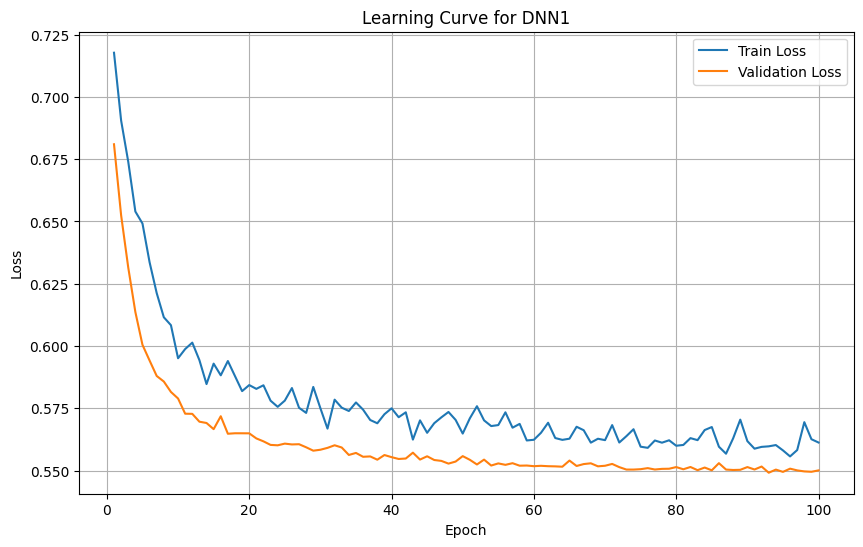

In [ ]:
best_params=study.best_params
model = DNN(input_dim=X_train_tensor.shape[1],
            hidden_units1=best_params["hidden_units1"],
            hidden_units2=best_params["hidden_units2"],
            hidden_units3=best_params["hidden_units3"],
            hidden_units4=best_params["hidden_units4"],
            dropout_rate=best_params["dropout_rate"]
            ).to(device)

# 最適化と訓練を実行
optimizer = optim.Adam(model.parameters(), lr=best_params["learning_rate"],weight_decay=best_params["weight_decay"])
criterion = nn.BCELoss()

num_epochs=100
train_losses = []
val_losses = []

model.train()
for epoch in range(num_epochs):
    epoch_train_loss = 0
    epoch_val_loss = 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch).squeeze()
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()
    avg_train_loss = epoch_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_train_loss:.4f}')

    if val_loader is not None:
        model.eval()  
        with torch.no_grad():
            for X_val, y_val in val_loader:
                X_val, y_val = X_val.to(device), y_val.to(device)
                val_outputs = model(X_val).squeeze()
                val_loss = criterion(val_outputs, y_val)
                epoch_val_loss += val_loss.item()

        avg_val_loss = epoch_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        model.train()  

    if val_loader is not None:
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
    else:
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
if val_losses:
    plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curve for DNN1')
plt.legend()
plt.grid()
plt.show()

Accuracy: 60.25%
Precision: 0.4878
Recall: 0.5900
F1 Score: 0.5340
Matthews Correlation Coefficient: 0.1955
Specificity: 0.6104


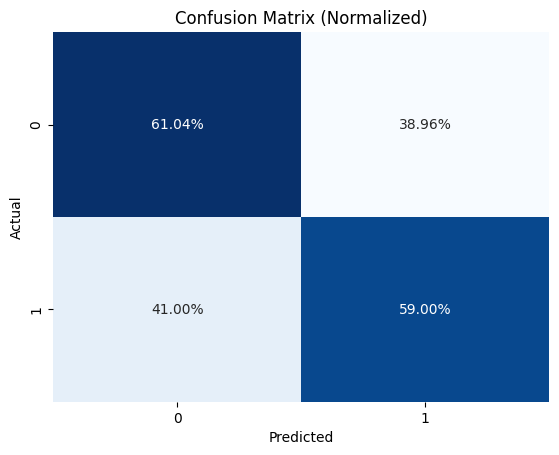

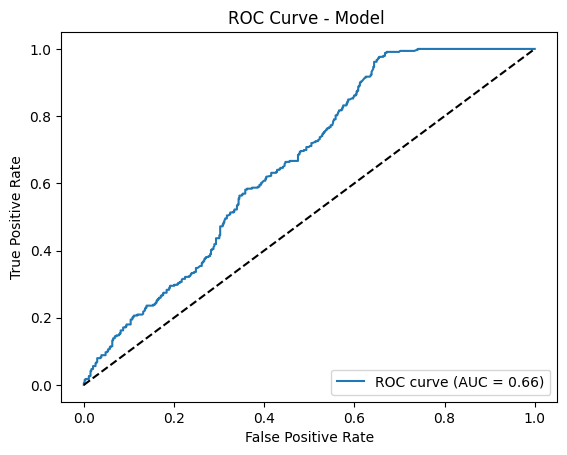

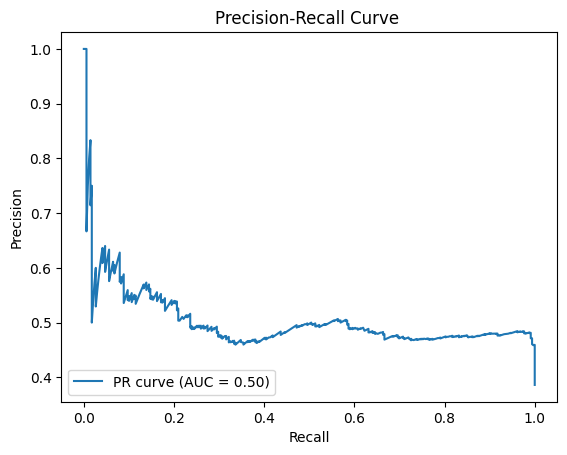

In [17]:
model.eval()
with torch.no_grad():
    X_test_tensor = X_test_tensor.to(device)
    y_test_tensor = y_test_tensor.to(device)

    # 予測と確率
    test_outputs = model(X_test_tensor).squeeze()
    predictions = (test_outputs >= 0.5).float()
    y_true = y_test_tensor.cpu().numpy()
    y_pred = predictions.cpu().numpy()
    y_prob = test_outputs.cpu().numpy()

# 評価指標
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    mcc = matthews_corrcoef(y_true, y_pred)
    specificity = recall_score(y_true, y_pred, pos_label=0)  
    print(f'Accuracy: {accuracy * 100:.2f}%')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print(f'Matthews Correlation Coefficient: {mcc:.4f}')
    print(f'Specificity: {specificity:.4f}')

    # 混同行列（割合表示）
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    sns.heatmap(cm, annot=True, fmt=".2%", cmap="Blues", cbar=False)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix (Normalized)")
    plt.show()

    # ROC曲線とAUC
    fpr, tpr, thresholds = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--') 
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - Model ')
    plt.legend(loc="lower right")
    plt.show()

    # Precision-Recall曲線
    precision_curve, recall_curve, pr_thresholds = precision_recall_curve(y_true, y_prob)
    pr_auc = auc(recall_curve, precision_curve)
    plt.plot(recall_curve, precision_curve, label=f'PR curve (AUC = {pr_auc:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve ')
    plt.legend(loc="lower left")
    plt.show()    

In [18]:
# モデルと構造を保存
torch.save(model, '../../saved_model/DNN_1.pth')
